In [1]:
import torch
import time
from datasets import load_dataset
from transformers import AutoTokenizer
from gptqmodel import GPTQModel, QuantizeConfig
from gptqmodel.utils import Perplexity
import matplotlib.pyplot as plt
import numpy as np
import gc

In [3]:
from huggingface_hub import login
login()

In [4]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If available, print the CUDA version
if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")

# Print the device name
device_name = torch.cuda.get_device_name(0) if cuda_available else "No CUDA device found"
print(f"Device Name: {device_name}")


CUDA Available: True
CUDA Version: 12.1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from gptqmodel import GPTQModel, QuantizeConfig

model_id = "meta-llama/Llama-3.2-1B-Instruct"
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_id)

print("LOADING DATASET")
calibration_dataset = [
  tokenizer(example["text"])
  for example in load_dataset(
    "allenai/c4",
    data_files="en/c4-train.00001-of-01024.json.gz",
    split="train"
  ).select(range(1024))
]
print("DATASET LOADED")

calibration_dataset = calibration_dataset[:10]

## choose number of bits for quantization
quant_config = QuantizeConfig(bits=4, group_size=128)

print("LOADING MODEL")
model = GPTQModel.load(model_id, quant_config)
print("MODEL LOADED")

print("QUANTIZING...")
model.quantize(calibration_dataset,  backend="cpu")

print("SAVING...")
model.save(quant_path)

print("LOADING...")
model = GPTQModel.load(quant_path)

result = model.generate(
  **tokenizer(
      "Uncovering deep insights begins with", return_tensors="pt"
  ).to(model.device)
)[0]

In [4]:
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-4bit"

print("LOADING...")
model = GPTQModel.load(quant_path)
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

result = model.generate(
  **tokenizer(
      "Uncovering deep insights begins with", return_tensors="pt"
  ).to(model.device)
)[0]

LOADING...


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from gptqmodel import GPTQModel, QuantizeConfig

def get_wikitext2(tokenizer, nsamples, seqlen):
    traindata = load_dataset("wikitext", "wikitext-2-raw-v1", split="train").filter(
        lambda x: len(x["text"]) >= seqlen)

    return [tokenizer(example["text"]) for example in traindata.select(range(nsamples))]



model_id = "meta-llama/Llama-3.2-1B-Instruct"
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the wikitext dataset
print("LOADING DATASET")
traindataset = get_wikitext2(tokenizer, nsamples=256, seqlen=1024)
print("DATASET LOADED")

# Choose number of bits for quantization
quant_config = QuantizeConfig(bits=4, group_size=128)

print("LOADING MODEL")
model = GPTQModel.load(model_id, quant_config)
print("MODEL LOADED")

print("QUANTIZING...")
model.quantize(traindataset)

print("SAVING...")
model.save(quant_path)

print("LOADING...")
model = GPTQModel.load(quant_path)

result = model.generate(
  **tokenizer(
      "Uncovering deep insights begins with", return_tensors="pt"
  ).to(model.device)
)[0]


In [5]:
# Function to calculate Perplexity (PPL)
@torch.no_grad()
def calculate_avg_ppl(model, tokenizer, dataset_path="wikitext", dataset_name="wikitext-2-raw-v1", split="train"):
    ppl = Perplexity(
        model=model,
        tokenizer=tokenizer,
        dataset_path=dataset_path,
        dataset_name=dataset_name,
        split=split,
        text_column="text",
    )

    all = ppl.calculate(n_ctx=512, n_batch=512)

    # Average Perplexity
    avg = sum(all) / len(all)

    return avg


# Function to load and process the wikitext dataset
def get_wikitext2(tokenizer, nsamples, seqlen):
    traindata = load_dataset("wikitext", "wikitext-2-raw-v1", split="train").filter(
        lambda x: len(x["text"]) >= seqlen)

    return [tokenizer(example["text"]) for example in traindata.select(range(nsamples))]

In [6]:
def quantize_model(dataset, quant_path, model_id, num_bits, group_size = 128):
    quant_config = QuantizeConfig(bits=num_bits, group_size=group_size)
    model = GPTQModel.load(model_id, quant_config)
    print(f"QUANTIZING WITH {num_bits} bits and group size of {group_size} ")
    model.quantize(dataset)
    print("SAVING MODEL")
    model.save(quant_path)

def quantize_for_all_bits_precision(dataset, model_id, group_size = 128):
    for num_bits in [2, 3, 4, 8]:
        quant_path = f"Llama-3.2-1B-Instruct-gptqmodel-{num_bits}bit-{group_size}gs"
        quantize_model(dataset, quant_path, model_id, num_bits, group_size = group_size)

In [39]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
print("LOADING DATASET")
traindataset = get_wikitext2(tokenizer, nsamples=256, seqlen=1024)
print("DATASET LOADED")
quantize_for_all_bits_precision(traindataset, model_id)

LOADING DATASET
DATASET LOADED


WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 4 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.62014', 'damp': '0.01000', 'time': '1.384'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01660', 'damp': '0.01000', 'time': '1.370'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '1.27480', 'damp': '0.01000', 'time': '1.234'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00164', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '1.13989', 'damp': '0.01000', 'time': '1.122'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '1.43341', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00756', 'damp': '0.01000', 'time': '4.789'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:01:56 / 0:15:28 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '1.05103', 'damp': '0.01000', 'time': '1.004'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.06223', 'damp': '0.01000', 'time': '1.141'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '2.02254', 'damp': '0.01000', 'time': '1.197'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00474', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '1.67089', 'damp': '0.01000', 'time': '1.072'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '2.28826', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '5.47714', 'damp': '0.01000', 'time': '4.606'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:03:54 / 0:20:48 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '2.13145', 'damp': '0.01000', 'time': '0.951'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.14697', 'damp': '0.01000', 'time': '1.145'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '4.06626', 'damp': '0.01000', 'time': '1.424'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00621', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '2.17195', 'damp': '0.01000', 'time': '1.026'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '3.43811', 'damp': '0.01000', 'time': '0.980'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.02579', 'damp': '0.01000', 'time': '4.556'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:05:57 / 0:23:48 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '1.39290', 'damp': '0.01000', 'time': '1.059'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.18991', 'damp': '0.01000', 'time': '1.068'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '3.04391', 'damp': '0.01000', 'time': '1.220'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.01221', 'damp': '0.01000', 'time': '1.026'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '2.57169', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '5.09807', 'damp': '0.01000', 'time': '1.125'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.03694', 'damp': '0.01000', 'time': '4.737'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:07:55 / 0:25:20 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '1.42607', 'damp': '0.01000', 'time': '0.969'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.17019', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '2.95491', 'damp': '0.01000', 'time': '1.003'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.01923', 'damp': '0.01000', 'time': '1.038'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '2.50548', 'damp': '0.01000', 'time': '0.980'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '5.38534', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.04074', 'damp': '0.01000', 'time': '4.251'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:09:50 / 0:26:13 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '2.17936', 'damp': '0.01000', 'time': '1.163'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.14247', 'damp': '0.01000', 'time': '1.247'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '3.71173', 'damp': '0.01000', 'time': '1.231'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.01942', 'damp': '0.01000', 'time': '1.094'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '2.64294', 'damp': '0.01000', 'time': '1.057'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '4.85856', 'damp': '0.01000', 'time': '1.181'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.04861', 'damp': '0.01000', 'time': '4.802'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:11:50 / 0:27:02 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '1.64679', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.18011', 'damp': '0.01000', 'time': '1.019'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '2.62159', 'damp': '0.01000', 'time': '1.126'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.03072', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '2.65523', 'damp': '0.01000', 'time': '1.109'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '4.75024', 'damp': '0.01000', 'time': '1.226'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.04964', 'damp': '0.01000', 'time': '4.396'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:13:45 / 0:27:30 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '1.61762', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.20405', 'damp': '0.01000', 'time': '0.935'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '3.05333', 'damp': '0.01000', 'time': '1.052'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.02708', 'damp': '0.01000', 'time': '0.942'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '2.69283', 'damp': '0.01000', 'time': '0.958'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '4.34144', 'damp': '0.01000', 'time': '1.120'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.05376', 'damp': '0.01000', 'time': '4.322'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:15:39 / 0:27:49 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '1.89474', 'damp': '0.01000', 'time': '0.920'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.19292', 'damp': '0.01000', 'time': '1.009'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '3.12245', 'damp': '0.01000', 'time': '1.110'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.03453', 'damp': '0.01000', 'time': '0.929'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '2.95268', 'damp': '0.01000', 'time': '1.095'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '4.62903', 'damp': '0.01000', 'time': '1.103'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.07173', 'damp': '0.01000', 'time': '4.173'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:17:33 / 0:28:04 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '1.53122', 'damp': '0.01000', 'time': '0.899'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.23447', 'damp': '0.01000', 'time': '0.926'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '3.73604', 'damp': '0.01000', 'time': '1.153'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.04613', 'damp': '0.01000', 'time': '0.981'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '3.08657', 'damp': '0.01000', 'time': '0.962'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '5.01843', 'damp': '0.01000', 'time': '1.067'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.08492', 'damp': '0.01000', 'time': '4.239'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:19:26 / 0:28:16 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '1.83477', 'damp': '0.01000', 'time': '0.902'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.25994', 'damp': '0.01000', 'time': '0.931'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '3.84458', 'damp': '0.01000', 'time': '1.154'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.03127', 'damp': '0.01000', 'time': '0.911'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '3.71283', 'damp': '0.01000', 'time': '0.979'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '5.81468', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.11023', 'damp': '0.01000', 'time': '4.200'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:21:19 / 0:28:25 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '2.29956', 'damp': '0.01000', 'time': '0.898'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.27798', 'damp': '0.01000', 'time': '0.889'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '3.92013', 'damp': '0.01000', 'time': '1.041'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.02644', 'damp': '0.01000', 'time': '0.902'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '4.22150', 'damp': '0.01000', 'time': '0.960'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '6.47687', 'damp': '0.01000', 'time': '1.191'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.12065', 'damp': '0.01000', 'time': '4.458'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:23:12 / 0:28:33 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '2.36638', 'damp': '0.01000', 'time': '0.860'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.28494', 'damp': '0.01000', 'time': '0.873'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '3.97809', 'damp': '0.01000', 'time': '1.063'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.02573', 'damp': '0.01000', 'time': '0.868'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '4.40740', 'damp': '0.01000', 'time': '0.898'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '6.40871', 'damp': '0.01000', 'time': '1.070'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.13805', 'damp': '0.01000', 'time': '3.996'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:25:04 / 0:28:38 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '2.33875', 'damp': '0.01000', 'time': '0.867'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.47960', 'damp': '0.01000', 'time': '0.873'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '4.59054', 'damp': '0.01000', 'time': '1.036'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.03183', 'damp': '0.01000', 'time': '0.934'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '5.22019', 'damp': '0.01000', 'time': '0.891'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '6.94502', 'damp': '0.01000', 'time': '0.947'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.20137', 'damp': '0.01000', 'time': '4.410'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:26:57 / 0:28:44 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '2.65161', 'damp': '0.01000', 'time': '1.052'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '1.07387', 'damp': '0.01000', 'time': '0.907'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '4.85614', 'damp': '0.01000', 'time': '1.012'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.07184', 'damp': '0.01000', 'time': '0.889'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '5.95376', 'damp': '0.01000', 'time': '0.971'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '8.56094', 'damp': '0.01000', 'time': '0.961'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.26770', 'damp': '0.01000', 'time': '4.191'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:28:49 / 0:28:49 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '2.52383', 'damp': '0.01000', 'time': '1.036'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '1.06734', 'damp': '0.01000', 'time': '1.039'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '4.41432', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.37918', 'damp': '0.01000', 'time': '0.880'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '7.41926', 'damp': '0.01000', 'time': '0.942'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '9.79895', 'damp': '0.01000', 'time': '0.995'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.64739', 'damp': '0.01000', 'time': '4.212'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.62014', 'damp': '0.01000', 'time': '1.384'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01660', 'damp': '0.01000', 'time': '1.370'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%2 / 2:14:24 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1485.55MB, 1.45GB
INFO - Size difference: 3228.77MB, 3.15GB - 68.49%
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 8 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00212', 'damp': '0.01000', 'time': '1.374'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00006', 'damp': '0.01000', 'time': '1.366'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.00436', 'damp': '0.01000', 'time': '1.190'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '0.987'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.00392', 'damp': '0.01000', 'time': '0.976'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.00493', 'damp': '0.01000', 'time': '1.114'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '4.383'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:01:54 / 0:15:12 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.00357', 'damp': '0.01000', 'time': '0.898'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.00021', 'damp': '0.01000', 'time': '0.920'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.00688', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.900'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.00573', 'damp': '0.01000', 'time': '0.964'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.00785', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '0.00274', 'damp': '0.01000', 'time': '4.260'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:03:47 / 0:20:10 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.00734', 'damp': '0.01000', 'time': '1.241'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.00051', 'damp': '0.01000', 'time': '1.156'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '0.01404', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.917'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.00747', 'damp': '0.01000', 'time': '0.979'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '0.01184', 'damp': '0.01000', 'time': '0.954'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00009', 'damp': '0.01000', 'time': '4.387'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:05:40 / 0:22:40 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.00464', 'damp': '0.01000', 'time': '0.868'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.00064', 'damp': '0.01000', 'time': '0.963'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.01019', 'damp': '0.01000', 'time': '0.991'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '0.892'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.00871', 'damp': '0.01000', 'time': '1.143'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '0.01724', 'damp': '0.01000', 'time': '1.059'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00013', 'damp': '0.01000', 'time': '4.204'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:07:33 / 0:24:09 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.00474', 'damp': '0.01000', 'time': '1.149'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.00057', 'damp': '0.01000', 'time': '0.957'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.00985', 'damp': '0.01000', 'time': '1.140'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00007', 'damp': '0.01000', 'time': '0.936'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.00852', 'damp': '0.01000', 'time': '1.068'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '0.01827', 'damp': '0.01000', 'time': '0.975'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.00014', 'damp': '0.01000', 'time': '4.097'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:09:27 / 0:25:12 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.00728', 'damp': '0.01000', 'time': '0.987'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.00048', 'damp': '0.01000', 'time': '1.088'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '0.01225', 'damp': '0.01000', 'time': '1.260'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00007', 'damp': '0.01000', 'time': '0.885'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.00896', 'damp': '0.01000', 'time': '0.969'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '0.01642', 'damp': '0.01000', 'time': '0.990'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.00017', 'damp': '0.01000', 'time': '3.917'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:11:19 / 0:25:52 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.00550', 'damp': '0.01000', 'time': '0.884'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.00061', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.00877', 'damp': '0.01000', 'time': '0.992'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00010', 'damp': '0.01000', 'time': '1.095'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.00898', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '0.01606', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.00017', 'damp': '0.01000', 'time': '4.068'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:13:12 / 0:26:24 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.00538', 'damp': '0.01000', 'time': '0.935'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.00069', 'damp': '0.01000', 'time': '0.945'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.01020', 'damp': '0.01000', 'time': '1.073'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00009', 'damp': '0.01000', 'time': '0.917'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.00910', 'damp': '0.01000', 'time': '0.962'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '0.01470', 'damp': '0.01000', 'time': '1.060'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.00018', 'damp': '0.01000', 'time': '4.319'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:15:05 / 0:26:48 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.00634', 'damp': '0.01000', 'time': '1.012'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.00065', 'damp': '0.01000', 'time': '1.088'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '0.01048', 'damp': '0.01000', 'time': '1.115'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00012', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.00999', 'damp': '0.01000', 'time': '0.998'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '0.01565', 'damp': '0.01000', 'time': '1.140'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.00024', 'damp': '0.01000', 'time': '4.375'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:16:57 / 0:27:07 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.00513', 'damp': '0.01000', 'time': '1.061'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.00079', 'damp': '0.01000', 'time': '0.951'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '0.01255', 'damp': '0.01000', 'time': '0.996'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.00016', 'damp': '0.01000', 'time': '0.943'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.01046', 'damp': '0.01000', 'time': '0.949'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '0.01698', 'damp': '0.01000', 'time': '1.163'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.00029', 'damp': '0.01000', 'time': '4.339'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:18:50 / 0:27:23 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.00620', 'damp': '0.01000', 'time': '0.949'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.00092', 'damp': '0.01000', 'time': '0.990'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '0.01298', 'damp': '0.01000', 'time': '1.039'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00011', 'damp': '0.01000', 'time': '0.950'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '0.01261', 'damp': '0.01000', 'time': '0.954'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '0.01974', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.00038', 'damp': '0.01000', 'time': '4.645'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:20:43 / 0:27:37 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.00777', 'damp': '0.01000', 'time': '0.905'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.00096', 'damp': '0.01000', 'time': '0.987'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '0.01328', 'damp': '0.01000', 'time': '1.163'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00009', 'damp': '0.01000', 'time': '0.912'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '0.01441', 'damp': '0.01000', 'time': '0.975'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '0.02210', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.00042', 'damp': '0.01000', 'time': '4.163'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:22:35 / 0:27:47 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.00809', 'damp': '0.01000', 'time': '0.946'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.00098', 'damp': '0.01000', 'time': '0.950'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '0.01353', 'damp': '0.01000', 'time': '1.031'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00009', 'damp': '0.01000', 'time': '0.983'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '0.01514', 'damp': '0.01000', 'time': '1.024'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '0.02201', 'damp': '0.01000', 'time': '1.040'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.00048', 'damp': '0.01000', 'time': '4.588'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:24:28 / 0:27:57 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.00799', 'damp': '0.01000', 'time': '0.950'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.00168', 'damp': '0.01000', 'time': '0.983'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '0.01570', 'damp': '0.01000', 'time': '1.121'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00011', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '0.01801', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '0.02394', 'damp': '0.01000', 'time': '0.987'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.00070', 'damp': '0.01000', 'time': '4.482'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:26:21 / 0:28:06 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.00904', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.00395', 'damp': '0.01000', 'time': '1.171'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '0.01656', 'damp': '0.01000', 'time': '1.099'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.00024', 'damp': '0.01000', 'time': '0.906'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '0.02054', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '0.02956', 'damp': '0.01000', 'time': '1.016'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.00093', 'damp': '0.01000', 'time': '4.258'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:28:14 / 0:28:14 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.00867', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.00374', 'damp': '0.01000', 'time': '1.166'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '0.01511', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.00132', 'damp': '0.01000', 'time': '0.935'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '0.02557', 'damp': '0.01000', 'time': '1.135'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '0.03385', 'damp': '0.01000', 'time': '1.129'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.00231', 'damp': '0.01000', 'time': '4.145'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00212', 'damp': '0.01000', 'time': '1.374'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00006', 'damp': '0.01000', 'time': '1.366'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%1 / 2:12:32 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1953.18MB, 1.91GB
INFO - Size difference: 2761.14MB, 2.70GB - 58.57%


In [14]:
import torch
import time
from datasets import load_dataset
from transformers import AutoTokenizer
from gptqmodel import GPTQModel, QuantizeConfig
from gptqmodel.utils import Perplexity



# Function to measure speed of model generation
def measure_inference_time(model, tokenizer, prompt, num_runs=10):
    start_time = time.time()
    for _ in range(num_runs):
        result = model.generate(
            **tokenizer(prompt, return_tensors="pt").to(model.device)
        )[0]
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time


model_id = "meta-llama/Llama-3.2-1B-Instruct"
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the wikitext dataset
print("LOADING DATASET")
traindataset = get_wikitext2(tokenizer, nsamples=256, seqlen=1024)
print("DATASET LOADED")

# Choose number of bits for quantization
quant_config = QuantizeConfig(bits=4, group_size=128)

print("LOADING MODEL")
model = GPTQModel.load(model_id, quant_config)
print("MODEL LOADED")

# Compute PPL for non-quantized model
print("Computing PPL for non-quantized model...")
non_quantized_ppl = calculate_avg_ppl(model, tokenizer)
print(f"Non-quantized model PPL: {non_quantized_ppl}")

# Measure speed of non-quantized model
print("Measuring inference speed for non-quantized model...")
non_quantized_speed = measure_inference_time(model, tokenizer, "Uncovering deep insights begins with")
print(f"Non-quantized model average inference time: {non_quantized_speed:.4f} seconds per generation")

print("QUANTIZING...")
model.quantize(traindataset)

print("SAVING...")
model.save(quant_path)

print("LOADING QUANTIZED MODEL...")
model = GPTQModel.load(quant_path)

# Compute PPL for quantized model
print("Computing PPL for quantized model...")
quantized_ppl = calculate_avg_ppl(model, tokenizer)
print(f"Quantized model PPL: {quantized_ppl}")

# Measure speed of quantized model
print("Measuring inference speed for quantized model...")
quantized_speed = measure_inference_time(model, tokenizer, "Uncovering deep insights begins with")
print(f"Quantized model average inference time: {quantized_speed:.4f} seconds per generation")

# Example question generation: comparing responses from both models
prompt = "What is the capital of France?"
print("\nQuestion: ", prompt)

# Summary
print("\nSUMMARY:")
print(f"Non-quantized model PPL: {non_quantized_ppl}")
print(f"Quantized model PPL: {quantized_ppl}")
print(f"Speed improvement (quantized vs non-quantized): {non_quantized_speed / quantized_speed:.2f}x faster")


LOADING DATASET
DATASET LOADED
LOADING MODEL
MODEL LOADED
Computing PPL for non-quantized model...
 Perplexity: 15.2052 |----------------------------------------| 100.0%3 / 0:05:33 [410/410] 100.0%

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Non-quantized model PPL: 15.922907671351842
Measuring inference speed for non-quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


Non-quantized model average inference time: 2.3167 seconds per generation
QUANTIZING...
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.62014', 'damp': '0.01000', 'time': '1.037'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01660', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '1.27480', 'damp': '0.01000', 'time': '1.101'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00164', 'damp': '0.01000', 'time': '1.019'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '1.13989', 'damp': '0.01000', 'time': '0.968'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '1.43341', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00756', 'damp': '0.01000', 'time': '4.020'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:01:22 / 0:10:56 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '1.05103', 'damp': '0.01000', 'time': '0.910'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.06223', 'damp': '0.01000', 'time': '0.990'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '2.02254', 'damp': '0.01000', 'time': '1.056'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00474', 'damp': '0.01000', 'time': '0.940'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '1.67089', 'damp': '0.01000', 'time': '0.982'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '2.28826', 'damp': '0.01000', 'time': '0.951'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '5.47714', 'damp': '0.01000', 'time': '4.253'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:02:58 / 0:15:49 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '2.13145', 'damp': '0.01000', 'time': '1.099'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.14697', 'damp': '0.01000', 'time': '1.248'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '4.06626', 'damp': '0.01000', 'time': '1.297'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00621', 'damp': '0.01000', 'time': '1.201'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '2.17195', 'damp': '0.01000', 'time': '1.368'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '3.43811', 'damp': '0.01000', 'time': '1.512'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.02579', 'damp': '0.01000', 'time': '5.629'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:04:27 / 0:17:48 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '1.39290', 'damp': '0.01000', 'time': '0.911'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.18991', 'damp': '0.01000', 'time': '0.996'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '3.04391', 'damp': '0.01000', 'time': '1.111'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.01221', 'damp': '0.01000', 'time': '0.926'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '2.57169', 'damp': '0.01000', 'time': '1.049'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '5.09807', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.03694', 'damp': '0.01000', 'time': '4.229'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:05:49 / 0:18:36 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '1.42607', 'damp': '0.01000', 'time': '0.894'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.17019', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '2.95491', 'damp': '0.01000', 'time': '1.313'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.01923', 'damp': '0.01000', 'time': '0.996'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '2.50548', 'damp': '0.01000', 'time': '0.961'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '5.38534', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.04074', 'damp': '0.01000', 'time': '4.051'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:07:15 / 0:19:20 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '2.17936', 'damp': '0.01000', 'time': '0.934'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.14247', 'damp': '0.01000', 'time': '0.981'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '3.71173', 'damp': '0.01000', 'time': '1.295'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.01942', 'damp': '0.01000', 'time': '0.900'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '2.64294', 'damp': '0.01000', 'time': '1.082'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '4.85856', 'damp': '0.01000', 'time': '1.112'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.04861', 'damp': '0.01000', 'time': '4.284'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:08:42 / 0:19:53 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '1.64679', 'damp': '0.01000', 'time': '0.900'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.18011', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '2.62159', 'damp': '0.01000', 'time': '0.966'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.03072', 'damp': '0.01000', 'time': '0.966'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '2.65523', 'damp': '0.01000', 'time': '1.102'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '4.75024', 'damp': '0.01000', 'time': '1.091'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.04964', 'damp': '0.01000', 'time': '4.489'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:10:04 / 0:20:08 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '1.61762', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.20405', 'damp': '0.01000', 'time': '1.044'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '3.05333', 'damp': '0.01000', 'time': '1.300'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.02708', 'damp': '0.01000', 'time': '0.990'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '2.69283', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '4.34144', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.05376', 'damp': '0.01000', 'time': '4.133'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:11:40 / 0:20:44 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '1.89474', 'damp': '0.01000', 'time': '1.036'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.19292', 'damp': '0.01000', 'time': '1.115'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '3.12245', 'damp': '0.01000', 'time': '1.290'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.03453', 'damp': '0.01000', 'time': '1.031'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '2.95268', 'damp': '0.01000', 'time': '0.969'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '4.62903', 'damp': '0.01000', 'time': '1.131'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.07173', 'damp': '0.01000', 'time': '4.082'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:13:01 / 0:20:49 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '1.53122', 'damp': '0.01000', 'time': '1.012'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.23447', 'damp': '0.01000', 'time': '1.045'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '3.73604', 'damp': '0.01000', 'time': '1.109'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.04613', 'damp': '0.01000', 'time': '1.024'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '3.08657', 'damp': '0.01000', 'time': '1.020'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '5.01843', 'damp': '0.01000', 'time': '1.169'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.08492', 'damp': '0.01000', 'time': '4.064'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:14:24 / 0:20:56 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '1.83477', 'damp': '0.01000', 'time': '1.009'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.25994', 'damp': '0.01000', 'time': '0.951'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '3.84458', 'damp': '0.01000', 'time': '1.060'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.03127', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '3.71283', 'damp': '0.01000', 'time': '1.017'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '5.81468', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.11023', 'damp': '0.01000', 'time': '4.460'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:15:46 / 0:21:01 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '2.29956', 'damp': '0.01000', 'time': '0.916'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.27798', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '3.92013', 'damp': '0.01000', 'time': '1.045'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.02644', 'damp': '0.01000', 'time': '1.087'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '4.22150', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '6.47687', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.12065', 'damp': '0.01000', 'time': '4.259'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:17:09 / 0:21:06 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '2.36638', 'damp': '0.01000', 'time': '0.939'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.28494', 'damp': '0.01000', 'time': '0.950'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '3.97809', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.02573', 'damp': '0.01000', 'time': '0.923'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '4.40740', 'damp': '0.01000', 'time': '1.035'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '6.40871', 'damp': '0.01000', 'time': '1.101'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.13805', 'damp': '0.01000', 'time': '4.654'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:18:31 / 0:21:09 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '2.33875', 'damp': '0.01000', 'time': '1.034'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.47960', 'damp': '0.01000', 'time': '0.909'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '4.59054', 'damp': '0.01000', 'time': '1.117'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.03183', 'damp': '0.01000', 'time': '0.950'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '5.22019', 'damp': '0.01000', 'time': '0.917'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '6.94502', 'damp': '0.01000', 'time': '0.981'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.20137', 'damp': '0.01000', 'time': '4.020'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:19:53 / 0:21:12 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '2.65161', 'damp': '0.01000', 'time': '0.917'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '1.07387', 'damp': '0.01000', 'time': '0.951'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '4.85614', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.07184', 'damp': '0.01000', 'time': '0.997'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '5.95376', 'damp': '0.01000', 'time': '1.034'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '8.56094', 'damp': '0.01000', 'time': '1.165'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.26770', 'damp': '0.01000', 'time': '4.036'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:21:15 / 0:21:15 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '2.52383', 'damp': '0.01000', 'time': '0.932'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '1.06734', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '4.41432', 'damp': '0.01000', 'time': '1.087'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.37918', 'damp': '0.01000', 'time': '0.905'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '7.41926', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '9.79895', 'damp': '0.01000', 'time': '0.971'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.64739', 'damp': '0.01000', 'time': '4.338'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.62014', 'damp': '0.01000', 'time': '1.037'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01660', 'damp': '0.01000', 'time': '0.984'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%6 / 2:03:12 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING...


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1485.55MB, 1.45GB
INFO - Size difference: 3228.77MB, 3.15GB - 68.49%


LOADING QUANTIZED MODEL...


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


Computing PPL for quantized model...


Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

 Perplexity: 19.1346 |----------------------------------------| 100.0%3 / 0:01:23 [410/410] 100.0%

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Quantized model PPL: 20.073740641036252
Measuring inference speed for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Quantized model average inference time: 0.7319 seconds per generation

Question:  What is the capital of France?
Non-quantized model response:


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


tensor([128000,   3923,    374,    279,   6864,    315,   9822,     30,  12366,
           198,   3923,    374,    279,   6864,    315,   9822,   5380,  60704,
           374,    279,   6864,    315,   9822,     13, 128009],
       device='cuda:0')
Quantized model response:
tensor([128000,   3923,    374,    279,   6864,    315,   9822,     30,  12366,
           198,   3923,    374,    279,   6864,    315,   9822,   5380,  60704,
           374,    279,   6864,    315,   9822,     13, 128009],
       device='cuda:0')

SUMMARY:
Non-quantized model PPL: 15.922907671351842
Quantized model PPL: 20.073740641036252
Speed improvement (quantized vs non-quantized): 3.17x faster


In [7]:
# Example question generation: comparing responses from both models
prompt = "What is the capital of France?"
print("\nQuestion: ", prompt)

# Non-quantized model response:
print("Non-quantized model response:")
non_quantized_result = model.generate(
  **tokenizer(prompt, return_tensors="pt").to(model.device)
)[0]

# Decode the generated token IDs to text
non_quantized_text = tokenizer.decode(non_quantized_result, skip_special_tokens=True)
print(non_quantized_text)

# Reload and generate response from quantized model
print("Quantized model response:")
quantized_result = model.generate(
  **tokenizer(prompt, return_tensors="pt").to(model.device)
)[0]

# Decode the generated token IDs to text
quantized_text = tokenizer.decode(quantized_result, skip_special_tokens=True)
print(quantized_text)


Question:  What is the capital of France?
Non-quantized model response:


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


What is the capital of France? Paris
The capital of France is Paris. Paris is the most populous city in France and is known
Quantized model response:
What is the capital of France? Paris
The capital of France is Paris. Paris is the most populous city in France and is known


#### To evaluate the model's performance on wikiText we will see how well it performs with random phrases from the test set, since there is no ground truth we will divide the lenghty phrases (len > 150) into input and ground truth

<li> Input will be composed of the first 100 characters till the tend of the current word, if any is found (e.g. if the phrases ends on "he likes buil-", it will become "he likes buildings")</li>
<li> The ground truth will be the rest of the phrase</li>

In [11]:
import re
test_data = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

for i in range(100):
    sample = test_data[i]["text"]
    input_cutoff = 100
    if len(sample) > input_cutoff:
        # Match up to the nearest word boundary after the cutoff
        match = re.match(r"^(.{100,}?\b)", sample[:150])  # Up to 150 characters
        if match:
            input_text = match.group(1)
        else:
            input_text = sample[:100]  # Fallback in case regex fails
    else:
        continue

    # Use the remaining text for the ground truth
    ground_truth_start = len(input_text)
    ground_truth = sample[ground_truth_start:]
    print(f"INPUT TEXT: {input_text}")
    print(f"GROUND TRUTH: {ground_truth}")


INPUT TEXT:  Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role
GROUND TRUTH:  on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . 

INPUT TEXT:  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He 


In [13]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch


# Load the wikitext test dataset
test_data = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

# Load the tokenizer and models (non-quantized and quantized)
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

quant_config = QuantizeConfig(bits=4, group_size=128)
# Prepare the non-quantized and quantized models
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-4bit"
non_quantized_model = GPTQModel.load(model_id, quant_config)  # Non-quantized
quantized_model = GPTQModel.load(quant_path)  # Quantized

# Define a function to evaluate the models
def evaluate_model_on_wikitext(test_data, tokenizer, model, input_cutoff = 150, num_samples=5, max_length=150):
    results = []
    i, counter = 0, 0
    while counter < num_samples:
        # Select a random example from the test set
        sample = test_data[i]["text"]

        # I only want lengthy samples to evaluate model's performance
        if len(sample) < 200:
            i += 1
            continue

        if len(sample) > input_cutoff:
            # Match up to the nearest word boundary after the cutoff
            match = re.match(r"^(.{100,}?\b)", sample[:170])  
            if match:
                input_text = match.group(1)
            else:
                continue  # Fallback in case regex fails
        else:
            continue

        # Use the remaining text for the ground truth
        ground_truth_start = len(input_text)
        ground_truth = sample[ground_truth_start:ground_truth_start + max_length]

        # Generate a response
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        output = model.generate(**inputs, max_length=max_length)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Store the result
        results.append({
            "input_text": input_text,
            "ground_truth": ground_truth,
            "generated_text": generated_text
        })

        counter += 1
        i += 1

    return results

# Evaluate both models
print("Evaluating non-quantized model...")
non_quantized_results = evaluate_model_on_wikitext(test_data, tokenizer, non_quantized_model)

print("Evaluating quantized model...")
quantized_results = evaluate_model_on_wikitext(test_data, tokenizer, quantized_model)

# Compare results
for i, (nq_res, q_res) in enumerate(zip(non_quantized_results, quantized_results)):
    print(f"\nSample {i+1}:")
    print("Input Text:", nq_res["input_text"])
    print("Ground Truth:", nq_res["ground_truth"])
    print("Non-Quantized Generated:", nq_res["generated_text"])
    print("Quantized Generated:", q_res["generated_text"])


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating non-quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 1:
Input Text:  Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role
Ground Truth:  on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed i
Non-Quantized Generated:  Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role in the 1980s and 1990s TV series "The Young Ones". He appeared in the 1984 film " The Wild Boys of London ". He also appeared in the 1990s TV series "The Bill". He has also appeared in the 1984 film " The Wild Boys of London " and the 1990s TV series " The Bill ". He also appeared in the 1984 film " The Wild Boys of London " and the 1990s TV series " The Bill ". He also appeared in the 1984 film " The Wild Boys of London "
Quantized Generated:  Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role in the 2010 film "The Twilight Saga: New

In [42]:
# Function to calculate Perplexity distribution
@torch.no_grad()
def calculate_ppl_distribution(model, tokenizer, dataset_path="wikitext", dataset_name="wikitext-2-raw-v1", split="test", n_chunks=10):
    ppl = Perplexity(
        model=model,
        tokenizer=tokenizer,
        dataset_path=dataset_path,
        dataset_name=dataset_name,
        split=split,
        text_column="text",
    )

    all_ppl = ppl.calculate(n_ctx=512, n_batch=512)
    chunk_size = len(all_ppl) // n_chunks
    distributions = [np.mean(all_ppl[i:i + chunk_size]) for i in range(0, len(all_ppl), chunk_size)]
    return distributions

def compute_ppl_distribution_for_all_bits(model_id, group_size = 128):
    ppl_distributions = []
    non_quant_model = GPTQModel.load(model_id, QuantizeConfig(bits=4, group_size=128))
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    print("COMPUTING PERPLEXITY FOR NON QUANTIZED MODEL")
    ppl_distributions.append(calculate_ppl_distribution(non_quant_model, tokenizer))

    for num_bits in [2, 3, 4, 8]:
        print(f"COMPUTING PERPLEXITY FOR {num_bits} BITS")
        quant_path = f"Llama-3.2-1B-Instruct-gptqmodel-{num_bits}bit-{group_size}gs"
        model = GPTQModel.load(quant_path)
        ppl_distributions.append(calculate_ppl_distribution(model, tokenizer))

    return ppl_distributions

def show_distributions(ppl_distributions):
    ppl_legend = {
        0: 'non-quantized',
        1: '2-bits',
        2: '3-bits',
        3: '4-bits',
        4: '8-bits',
    }

    plt.figure(figsize=(8, 5))
    for i in range(len(ppl_distributions)):
        plt.plot(ppl_distributions[i], label=ppl_legend[i], marker="o")

    plt.title("Perplexity Distribution")
    plt.xlabel("Chunk Index")
    plt.ylabel("Average Perplexity")
    plt.legend()
    plt.show()

COMPUTING PERPLEXITY FOR NON QUANTIZED MODEL


Parameter 'function'=<function Perplexity._prepare_data.<locals>.<lambda> at 0x00000194C939BD80> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

 Perplexity: 14.5253 |----------------------------------------| 100.0%3 / 0:05:23 [399/399] 100.0%COMPUTING PERPLEXITY FOR 2 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


 Perplexity: 4713.0921 |----------------------------------------| 100.0%1 / 0:01:21 [399/399] 100.0%COMPUTING PERPLEXITY FOR 3 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


 Perplexity: 28.6991 |----------------------------------------| 100.0%3 / 0:02:03 [399/399] 100.0%COMPUTING PERPLEXITY FOR 4 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

 Perplexity: 18.8967 |----------------------------------------| 100.0%9 / 0:01:19 [399/399] 100.0%COMPUTING PERPLEXITY FOR 8 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

 Perplexity: 17.3995 |----------------------------------------| 100.0%4 / 0:01:34 [399/399] 100.0%

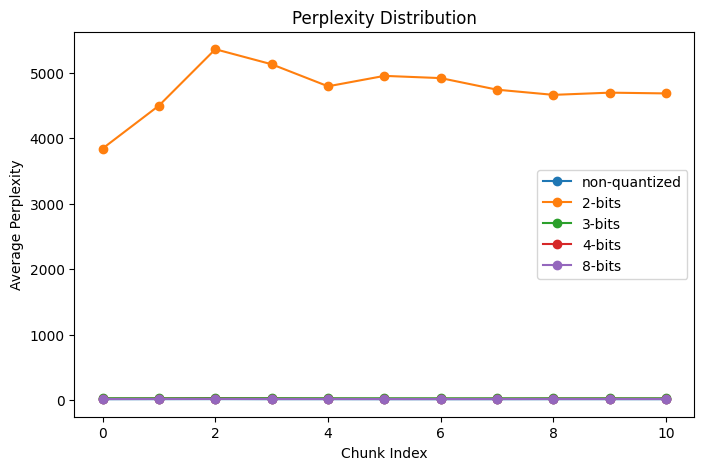

In [43]:
ppl_distributions = compute_ppl_distribution_for_all_bits(model_id)
show_distributions(ppl_distributions)

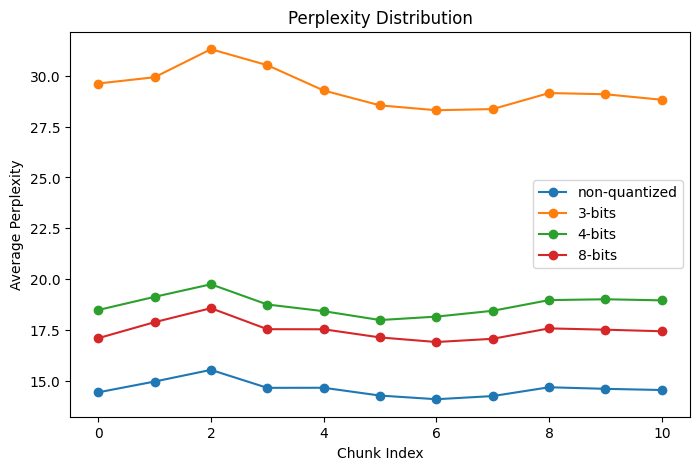

In [44]:
ppl_legend = {
        0: 'non-quantized',
        #1: '2-bits',
        2: '3-bits',
        3: '4-bits',
        4: '8-bits',
    }

plt.figure(figsize=(8, 5))
for i in range(len(ppl_distributions)):
    if i == 1:
        continue
    plt.plot(ppl_distributions[i], label=ppl_legend[i], marker="o")

plt.title("Perplexity Distribution")
plt.xlabel("Chunk Index")
plt.ylabel("Average Perplexity")
plt.legend()
plt.show()

Calculating PPL distribution for non-quantized model...


Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

 Perplexity: 15.2052 |----------------------------------------| 100.0%1 / 0:05:11 [410/410] 100.0%

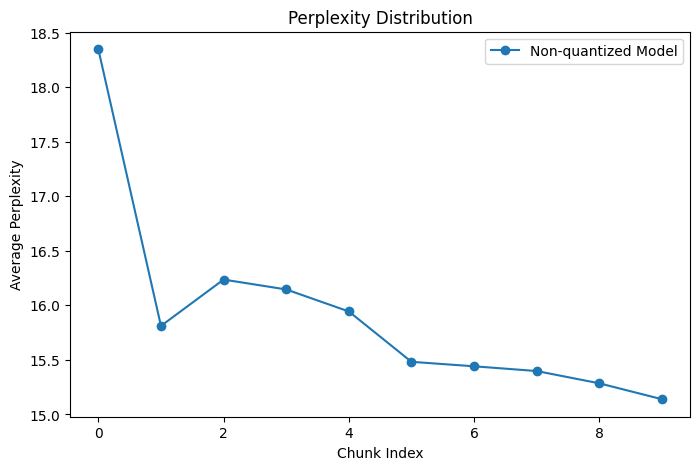

In [15]:
# Calculate PPL distribution
print("Calculating PPL distribution for non-quantized model...")
non_quantized_ppl_distribution = calculate_ppl_distribution(non_quantized_model, tokenizer)

# Plot PPL distribution
plt.figure(figsize=(8, 5))
plt.plot(non_quantized_ppl_distribution, label="Non-quantized Model", marker="o")
plt.title("Perplexity Distribution")
plt.xlabel("Chunk Index")
plt.ylabel("Average Perplexity")
plt.legend()
plt.show()


In [101]:
def measure_token_generation_speed(model, tokenizer, prompt, num_runs=10):
    total_tokens = 0
    start_time = time.time()
    for _ in range(num_runs):
        result = model.generate(
            **tokenizer(prompt, return_tensors="pt").to(model.device)
        )
        total_tokens += result.shape[-1]  # Number of tokens in the output
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    tokens_per_second = total_tokens / (end_time - start_time)
    return avg_time, tokens_per_second

def measure_token_generation_speed_for_all_bits(model_id, group_size = 128):
    avg_times = []
    tokens_per_seconds = []
    
    prompt = "Uncovering deep insights begins with"

    non_quant_model = GPTQModel.load(model_id, QuantizeConfig(bits=4, group_size=group_size))
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    print("COMPUTING SPEED FOR NON QUANTIZED MODEL")
    nq_avg_time, nq_tokens_per_second = measure_token_generation_speed(non_quant_model, tokenizer, prompt)

    for num_bits in [8, 4, 3, 2]:
        print(f"COMPUTING PERPLEXITY FOR {num_bits} BITS")
        quant_path = f"Llama-3.2-1B-Instruct-gptqmodel-{num_bits}bit-{group_size}gs"
        model = GPTQModel.load(quant_path)
        avg_time, tokens_per_second = measure_token_generation_speed(model, tokenizer, prompt)
        avg_times.append(avg_time)
        tokens_per_seconds.append(tokens_per_second)
    
    
    return nq_avg_time, nq_tokens_per_second, avg_times, tokens_per_seconds

def print_speedup(nq_avg_time, nq_tokens_per_second, avg_times, tokens_per_seconds):
    ppl_legend = {
        3: '2 bits',
        2: '3 bits',
        1: '4 bits',
        0: '8 bits',
    }

    speedups = []
    print(f"Non-quantized model average inference time: {nq_avg_time:.4f} seconds per generation")
    print(f"Tokens per second for non quantized model: {nq_tokens_per_second:.2f}")

    speedups.append(1)
    for i in range(len(avg_times)):
        print(f"CONSIDERING MODEL QUANTIZED WITH {ppl_legend[i]}")
        print(f"model average inference time: {avg_times[i]:.4f} seconds per generation")
        print(f"Speedup is : {nq_avg_time / avg_times[i]:.2f} times")
        print(f"Tokens per second for non quantized model: {tokens_per_seconds[i]:.2f}")
        speedups.append(nq_avg_time / avg_times[i])

    configurations = ["nq", "8-bit", "4-bit", "3-bit", "2-bit"]

    plt.plot(configurations, speedups, marker='o', color='orange')
    plt.ylabel("Speedup Factor")
    plt.title("Speedup Factor Across Quantization Levels")
    plt.show()

    return speedups

In [102]:
nq_avg_time, nq_tokens_per_second, avg_times, tokens_per_seconds = measure_token_generation_speed_for_all_bits(model_id)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


COMPUTING SPEED FOR NON QUANTIZED MODEL


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


COMPUTING PERPLEXITY FOR 8 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


COMPUTING PERPLEXITY FOR 4 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


COMPUTING PERPLEXITY FOR 3 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


COMPUTING PERPLEXITY FOR 2 BITS


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Non-quantized model average inference time: 2.3935 seconds per generation
Tokens per second for non quantized model: 11.28
CONSIDERING MODEL QUANTIZED WITH 8 bits
model average inference time: 0.8288 seconds per generation
Speedup is : 2.89 times
Tokens per second for non quantized model: 32.58
CONSIDERING MODEL QUANTIZED WITH 4 bits
model average inference time: 0.8241 seconds per generation
Speedup is : 2.90 times
Tokens per second for non quantized model: 32.76
CONSIDERING MODEL QUANTIZED WITH 3 bits
model average inference time: 1.1447 seconds per generation
Speedup is : 2.09 times
Tokens per second for non quantized model: 23.59
CONSIDERING MODEL QUANTIZED WITH 2 bits
model average inference time: 0.7245 seconds per generation
Speedup is : 3.30 times
Tokens per second for non quantized model: 37.27


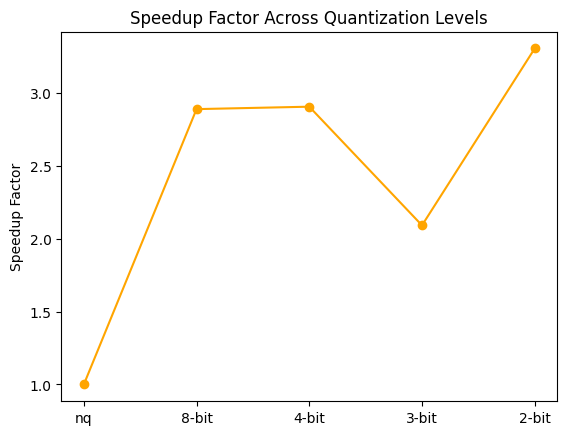

In [103]:
speedups = print_speedup(nq_avg_time, nq_tokens_per_second, avg_times, tokens_per_seconds)

In [ ]:
# Measure token generation speed
print("Measuring token generation speed for non-quantized model...")
non_quantized_avg_time, non_quantized_tokens_per_sec = measure_token_generation_speed(non_quantized_model, tokenizer, "Uncovering deep insights begins with")
print(f"Non-quantized model: {non_quantized_tokens_per_sec:.2f} tokens/second")
print(f"Non-quantized avg time: {non_quantized_avg_time:.2f}")

quantized_avg_time, quantized_tokens_per_sec = measure_token_generation_speed(quantized_model, tokenizer, "Uncovering deep insights begins with")
print(f"Non-quantized model: {quantized_tokens_per_sec:.2f} tokens/second")
print(f"Quantized avg time: {quantized_avg_time:.2f}")

print(f"Speed improvement (quantized vs non-quantized): {non_quantized_avg_time / quantized_avg_time:.2f}x faster")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Measuring token generation speed for non-quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Non-quantized model: 11.40 tokens/second
Non-quantized avg time: 2.37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Non-quantized model: 36.97 tokens/second
Quantized avg time: 0.73
Speed improvement (quantized vs non-quantized): 3.24x faster


In [ ]:
def measure_token_generation_speed(model, tokenizer, prompt, num_runs=10):
    total_tokens = 0
    start_time = time.time()
    for _ in range(num_runs):
        result = model.generate(
            **tokenizer(prompt, return_tensors="pt").to(model.device)
        )
        total_tokens += result.shape[-1]  # Number of tokens in the output
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    tokens_per_second = total_tokens / (end_time - start_time)
    return avg_time, tokens_per_second



### MEMORY CONSUMPTION STILL DOESN'T WORK!

In [ ]:
def compute_theoretical_model_memory_quantized(model, bit_width):
    # Bytes per parameter for the given bit-width
    bytes_per_param = bit_width / 8.0

    total_params = 0
    total_memory = 0

    for name, param in model.named_parameters():
        num_params = param.numel()  # Total number of parameters
        layer_memory = num_params * bytes_per_param
        total_params += num_params
        total_memory += layer_memory
        #print(f"Layer: {name}, Parameters: {num_params}, Memory: {layer_memory / 1e6:.2f} MB")

    #print(f"\nQuantization Bit-Width: {bit_width}-bit")
    print(f"Total Parameters: {total_params}")
    print(f"Total Model Memory: {total_memory / 1e6:.2f} MB")
    return total_params, total_memory

# Example usage for different bit-width quantizations
quantized_model = GPTQModel.load(quant_path)

for bit_width in [2, 3, 4, 8, 32]:
    print(f"\nMemory for {bit_width}-bit Quantized Model:")
    compute_theoretical_model_memory_quantized(quantized_model, bit_width)

INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.



Memory for 2-bit Quantized Model:
Total Parameters: 262735872
Total Model Memory: 65.68 MB

Memory for 3-bit Quantized Model:
Total Parameters: 262735872
Total Model Memory: 98.53 MB

Memory for 4-bit Quantized Model:
Total Parameters: 262735872
Total Model Memory: 131.37 MB

Memory for 8-bit Quantized Model:
Total Parameters: 262735872
Total Model Memory: 262.74 MB

Memory for 32-bit Quantized Model:
Total Parameters: 262735872
Total Model Memory: 1050.94 MB


In [19]:
import torch

# Function to measure memory consumption during inference
def measure_memory_usage(model, tokenizer, prompt):
    torch.cuda.reset_peak_memory_stats()  # Reset memory stats
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        model.generate(**inputs)
    memory_usage = torch.cuda.max_memory_allocated() / (1024 ** 2)  # Convert to MB
    return memory_usage

# Measure memory usage
print("Measuring memory usage for non-quantized model...")
non_quantized_memory = measure_memory_usage(non_quantized_model, tokenizer, "Uncovering deep insights begins with")
print(f"Non-quantized model memory usage: {non_quantized_memory:.2f} MB")
quantized_memory = measure_memory_usage(quantized_model, tokenizer, "Uncovering deep insights begins with")
print(f"Quantized model memory usage: {quantized_memory:.2f} MB")

print(f"Memory footprint saved: {non_quantized_memory / quantized_memory} x less")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Measuring memory usage for non-quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Non-quantized model memory usage: 993.64 MB
quantized model memory usage: 995.92 MB
Memory footprint saved: 0.9977035309437439 x less


In [75]:
def measure_memory_footprint(model):
    # Clear unused memory and collect garbage
    torch.cuda.empty_cache()
    gc.collect()
    
    # Measure memory before and after loading the model
    memory_before = torch.cuda.memory_allocated()
    
    # Move model to GPU and synchronize to ensure accurate measurement
    model.to("cuda")
    torch.cuda.synchronize()
    memory_after = torch.cuda.memory_allocated()
    
    # Calculate difference
    memory_footprint = memory_after - memory_before
    
    return memory_footprint / (1024 ** 2)  # Convert to MB


In [77]:
# Measure memory footprint for non-quantized model
non_quantized_memory = measure_memory_footprint(non_quantized_model)
print(f"Non-quantized model memory footprint: {non_quantized_memory:.2f} MB")

# Measure memory footprint for quantized model
quant_path = f"Llama-3.2-1B-Instruct-gptqmodel-2bit-128gs"
model = GPTQModel.load(quant_path)
quantized_memory = measure_memory_footprint(model)
print(f"Quantized model memory footprint: {quantized_memory:.2f} MB")

Non-quantized model memory footprint: 0.00 MB


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.


Quantized model memory footprint: 0.00 MB


In [ ]:
c4_dataset = load_dataset("allenai/c4", name="en", split="train")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

c4-train.00000-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

c:\Users\galfanol\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\galfanol\.cache\huggingface\hub\datasets--allenai--c4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


c4-train.00002-of-01024.json.gz:   0%|          | 0.00/320M [00:00<?, ?B/s]

c4-train.00003-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

c4-train.00004-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

c4-train.00005-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

c4-train.00006-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

c4-train.00007-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

c4-train.00008-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

c4-train.00009-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

c4-train.00010-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

c4-train.00011-of-01024.json.gz:   0%|          | 0.00/320M [00:00<?, ?B/s]

c4-train.00012-of-01024.json.gz:   0%|          | 0.00/320M [00:00<?, ?B/s]

c4-train.00013-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

c4-train.00014-of-01024.json.gz:   0%|          | 0.00/320M [00:00<?, ?B/s]